In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from functools import partial


def flatten_image(x, label=False):
    if label:
        return (tf.divide(
            tf.dtypes.cast(
                tf.reshape(x["image"], (1, 28*28)), tf.float32), 256.0),
                x["label"])
    else:
        return (
            tf.divide(tf.dtypes.cast(
                tf.reshape(x["image"], (1, 28*28)), tf.float32), 256.0))

flatten_image = partial(flatten_image, label=True)


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()


In [3]:

info = mnist_builder.info
print(info)


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/vscode/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


2023-03-02 05:17:00.110230: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


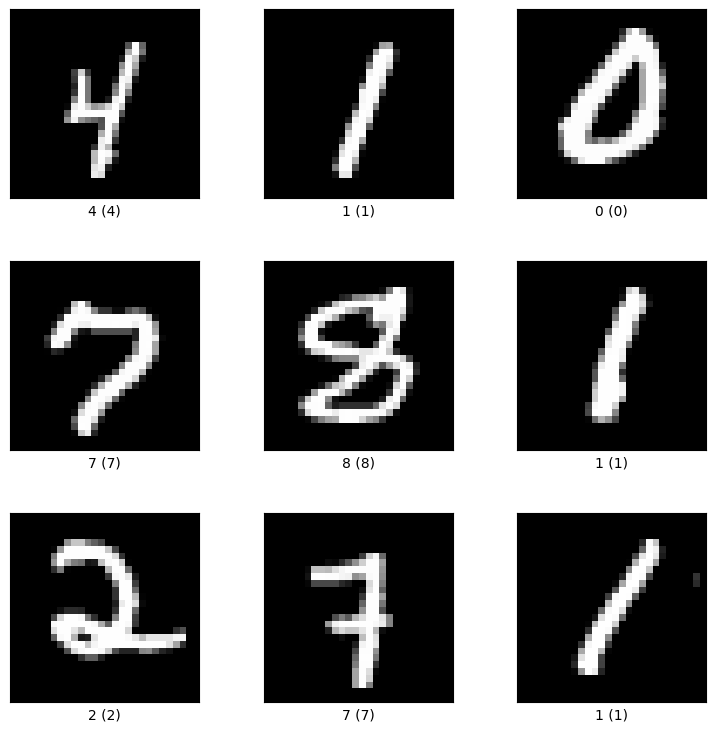

Label: 4


2023-03-02 05:17:00.329572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


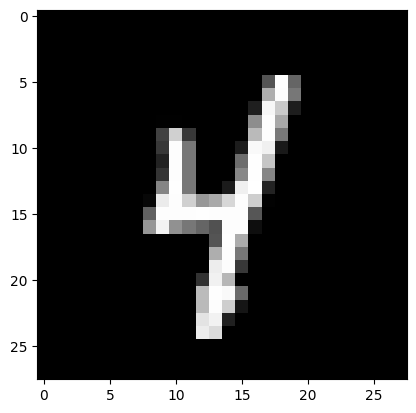

2023-03-02 05:17:00.430866: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


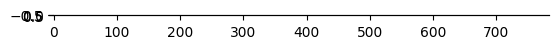

In [4]:
mnist_train = mnist_builder.as_dataset(split="train")
fig = tfds.show_examples(info, mnist_train)

for image, label in mnist_train.map(flatten_image).take(1):
    plt.imshow(image.numpy().reshape(28, 28).astype(np.float32),
                cmap=plt.get_cmap("gray"))
    print("Label: %d" % label.numpy())
plt.show()

for image, label in mnist_train.map(flatten_image).take(1):
    plt.imshow(image.numpy().astype(np.float32),
                cmap=plt.get_cmap("gray"))
plt.show()


In [10]:
from tensorflow.keras import layers
import tensorflow_probability as tfp


class RBM(layers.Layer):
    """A custom layer that represents Restricted Boltzmann Machines."""

    def __init__(self, hidden_units, visible_units=None, learning_rate=0.1, cd_steps=1) -> None:
        """Initialize RBM."""
        super().__init__()
        self.hidden_units = hidden_units
        self.visible_units = visible_units
        self.learning_rate = learning_rate
        self.cd_steps = cd_steps

    def build(self, input_shape) -> None:
        """Executed when we call model.compile() used to initialize weights in the network"""
        if not self.visible_units:
            self.visible_units = input_shape[-1]
        self.w_rec = self.add_weight(
            shape=(self.visible_units, self.hidden_units),
            initializer='random_normal',
            trainable=True,
        )
        self.w_gen = self.add_weight(
            shape=(self.hidden_units, self.visible_units),
            initializer='random_normal',
            trainable=True,
        )
        self.hb = self.add_weight(
            shape=(self.hidden_units,),
            initializer='random_normal',
            trainable=True,
        )
        self.vb = self.add_weight(
            shape=(self.visible_units,),
            initializer='random_normal',
            trainable=True,
        )

    def forward(self, x):
        """Compute sigmoidal activiations from the input."""
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_rec), self.hb))

    def sample_h(self, x):
        """Turn on/off hidden units based on activation probability."""
        u_sample = tfp.distributions.Uniform().sample(
            (x.shape[1], self.hb.shape[-1])
        )
        return tf.cast(self.forward(x) > u_sample, tf.float32)

    def reverse(self, x):
        """Sample in reverse for visible units."""
        return tf.sigmoid(tf.add(tf.matmul(x, self.w_gen), self.vb))

    def sample_v(self, x):
        """Turn on/off visible units based on activation probability."""
        u_sample = tfp.distributions.Uniform().sample(
            (x.shape[1], self.vb.shape[-1]))
        return tf.cast(self.reverse(x) > u_sample, tf.float32)

    def call(self, inputs):
        """Forward pass using fit()."""
        return tf.sigmoid(tf.add(tf.matmul(inputs, self.w), self.hb))

    def free_energy(self, x):
        """Calculates free energy.
        
        Used as a cost function? Models join distribution over visible and hidden variables in the model.
        """
        return -tf.tensordot(x, self.vb, 1) \
            - tf.reduce_sum(
                tf.math.log(
                    1+tf.math.exp(
                        tf.add(
                            tf.matmul(x, self.w_rec),
                            self.hb
                        )
                    )
                ), 1)

    def reverse_gibbs(self, x):
        """Forward and reverse gibb samples."""
        return self.sample_h(self.sample_v(x))
    
    def forward_gibbs(self, x):
        return self.sample_v(self.sample_h(x))

    def cd_update(self, x):
        with tf.GradientTape(watch_accessed_variables=False) as g:
            h_sample = self.sample_h(x)
            # Perform sample steps. Compute the cost using the difference between
            # the free energy of the data and the reconstructed data
            for _ in range(self.cd_steps):
                v_sample = tf.constant(self.sample_v(h_sample))
                h_sample = self.sample_h(v_sample)
            g.watch(self.w_rec)
            g.watch(self.hb)
            g.watch(self.vb)
            cost = tf.reduce_mean(self.free_energy(x)) - tf.reduce_mean(self.free_energy(v_sample))
            # Compute gradients of the three weight matrices and update their values
            w_grad, hb_grad, vb_grad = g.gradient(cost, [self.w_rec, self.hb, self.vb])
            self.w_rec.assign_sub(self.learning_rate * w_grad)
            self.w_gen = tf.Variable(tf.transpose(self.w_rec))  # force tieing
            self.hb.assign_sub(self.learning_rate * hb_grad)
            self.vb.assign_sub(self.learning_rate * vb_grad)
            # Return reconstruction cost as a way to monitor progress.
            return self.reconstruction_cost(x).numpy()
        
    def reconstruction_cost(self, x):
        """Reconstruction cost is the cross-entropy loss between the input and reconstructed data."""
        return tf.reduce_mean(
            tf.reduce_sum(
                tf.math.add(
                    tf.math.multiply(x, tf.math.log(self.reverse(self.forward(x)))),
                    tf.math.multiply(tf.math.subtract(1, x),tf.math.log(tf.math.subtract(1, self.reverse(self.forward(x)))))
                ), 1
            ),
        )


def train_rbm(rbm, data, map_fn, num_epochs, tolerance, batch_size, shuffle_buffer=1024):
    last_cost = None

    for epoch in range(num_epochs):
        cost = 0.0
        count = 0.0
        for datapoints in data.map(map_fn).shuffle(shuffle_buffer).batch(batch_size):
            cost += rbm.cd_update(datapoints)
            count += 1.0
        cost /= count
        print("epoch: {}, cost: {}".format(epoch, cost))
        if last_cost and abs(last_cost-cost) <= tolerance:
            print("Cost diff below tolerance: %s" % tolerance)
            break
        last_cost = cost

    return rbm

rbm = RBM(hidden_units=500)
rbm.build([784])

rbm = train_rbm(rbm, data=mnist_train, map_fn=partial(flatten_image, label=False), num_epochs=100, tolerance=1e-3, batch_size=1000)

epoch: 0, cost: -0.4302336643139521
epoch: 1, cost: -0.29188565363486607
epoch: 2, cost: -0.26916679590940473
epoch: 3, cost: -0.2608065947890282
epoch: 4, cost: -0.25656480590502423
epoch: 5, cost: -0.25390243356426556
epoch: 6, cost: -0.2522477696339289
epoch: 7, cost: -0.25138159344593686
Cost diff below tolerance: 0.001


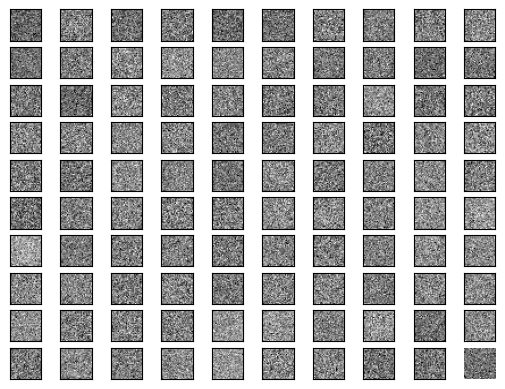

In [11]:
fig, axarr = plt.subplots(10, 10)
plt.axis('off')

for i in range(10):
    for j in range(10):
        fig.axes[i*10+j].get_xaxis().set_visible(False)
        fig.axes[i*10+j].get_yaxis().set_visible(False)
        n = rbm.w_rec.numpy()
        im = n[:,i*10+j].reshape(28,28)
        axarr[i,j].imshow(im, cmap=plt.get_cmap("gray"))

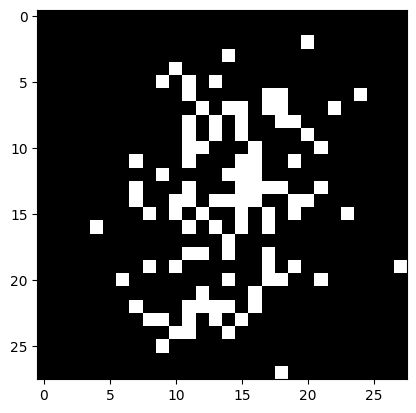

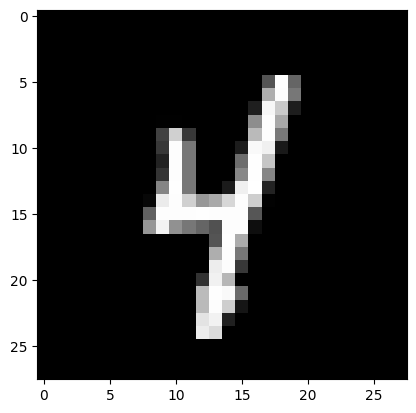

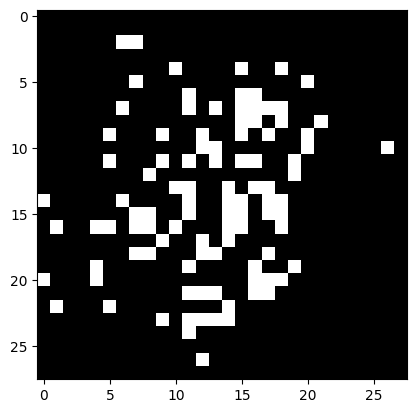

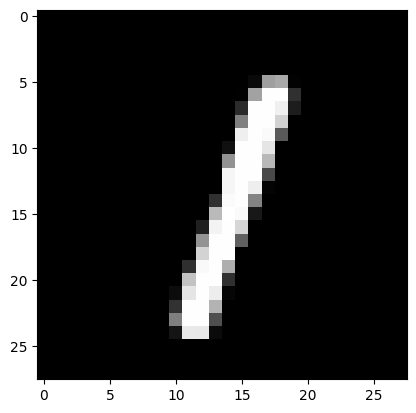

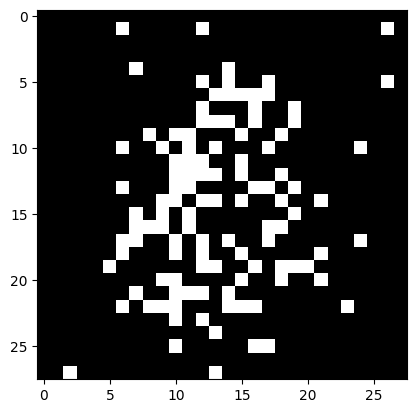

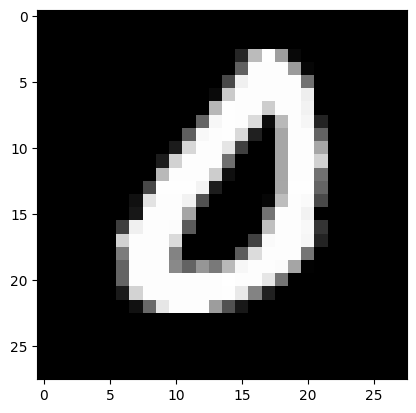

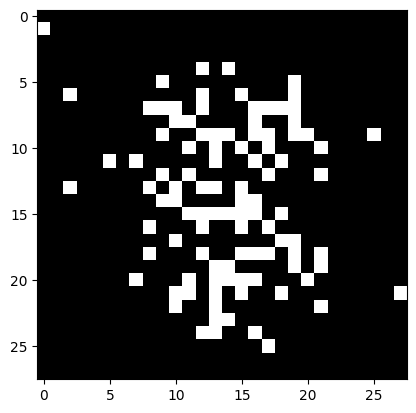

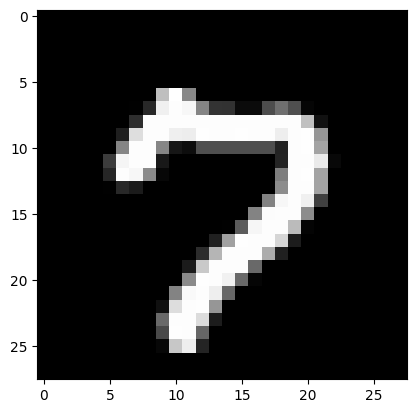

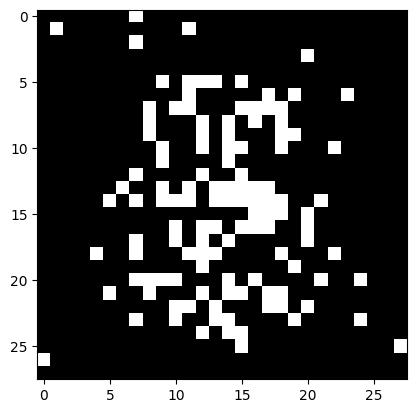

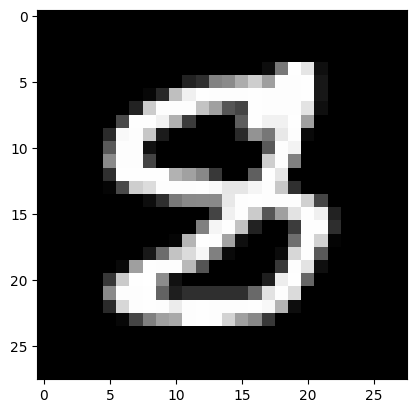

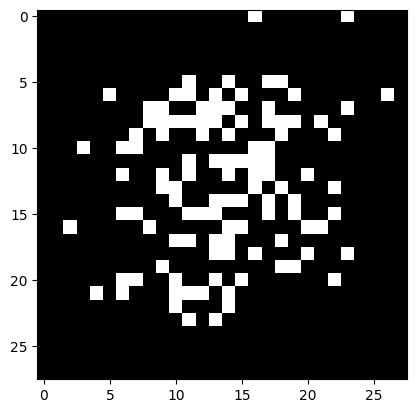

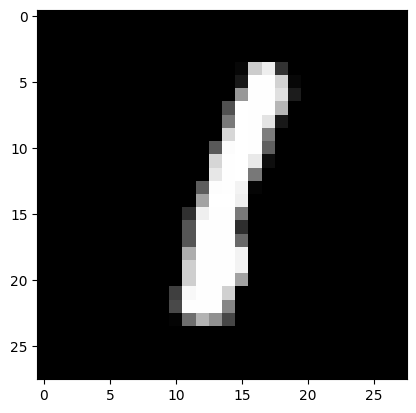

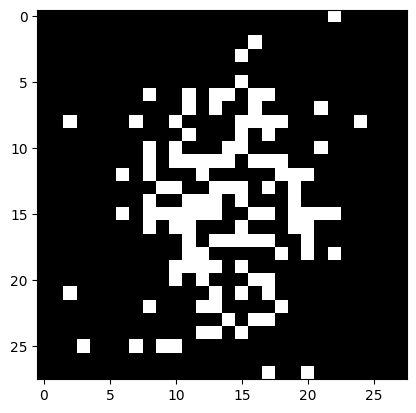

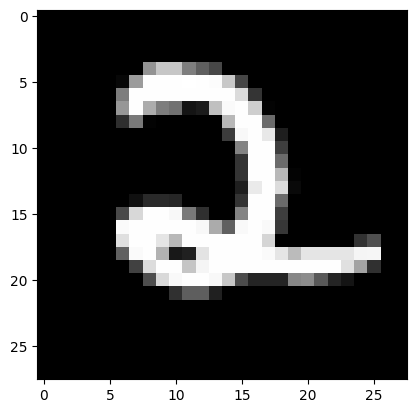

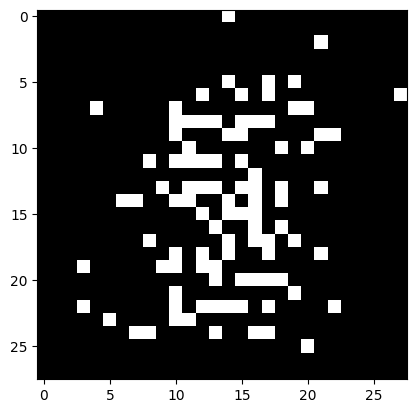

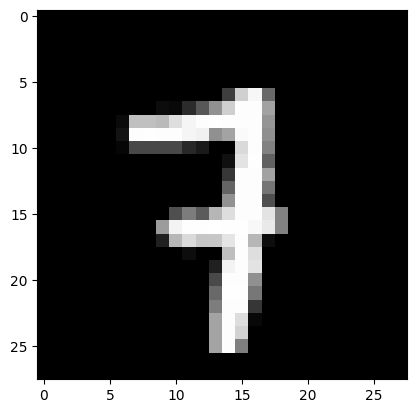

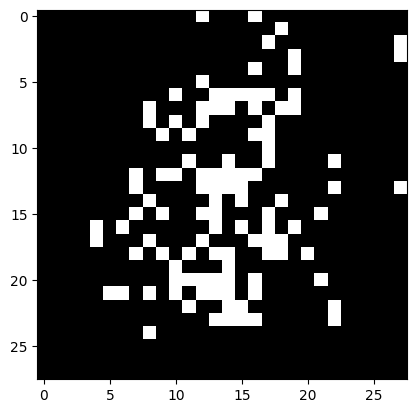

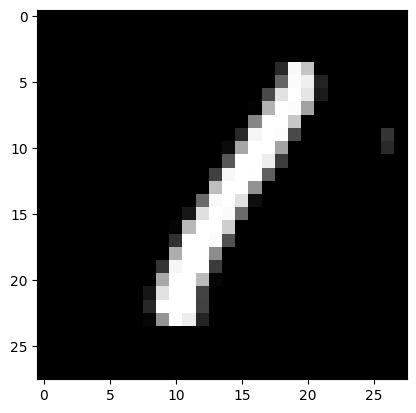

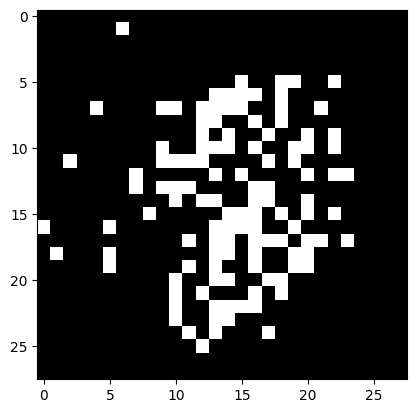

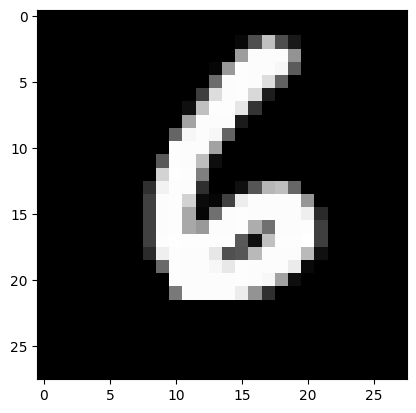

In [15]:
i = 0
for image, label in mnist_train.map(flatten_image).batch(1).take(10):
    plt.figure(i)
    plt.imshow(rbm.forward_gibbs(image).numpy().reshape(28,28).astype(np.float32), cmap=plt.get_cmap("gray"))
    i += 1
    plt.figure(i)
    plt.imshow(image.numpy().reshape(28,28).astype(np.float32), cmap=plt.get_cmap("gray"))
    i += 1

